In [1]:
import setproctitle

setproctitle.setproctitle("data")

In [2]:
import gc
import os
import sys
import time

import catboost
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm

tqdm.pandas()

In [3]:
# df = pd.read_csv('/home/asciishell/s3/jupyter.asciishell.ru/accepted_2007_to_2018Q4.csv', low_memory=False)
df = pd.read_parquet("/home/asciishell/s3/jupyter.asciishell.ru/accepted_2007_to_2018Q4.parquet")

In [4]:
for col in (
    "earliest_cr_line",
    "sec_app_earliest_cr_line",
    "issue_d",
    "last_pymnt_d",
    "next_pymnt_d",
    "last_credit_pull_d",
):
    df[col] = pd.to_datetime(df[col])

In [5]:
df["loan_status2"] = df["loan_status"].map(
    {
        "Fully Paid": 0,
        # "Current": -1,
        "Charged Off": 1,
        # "Late (31-120 days)": 2,
        # "In Grace Period": -1,
        # "Late (16-30 days)": -1,
        "Does not meet the credit policy. Status:Fully Paid": 0,
        "Does not meet the credit policy. Status:Charged Off": 1,
        "Default": 1,
    }
)
df.loc[df["loan_status"] == "Late (31-120 days)", "loan_status2"] = (
    pd.Timestamp("2019-04-01") - df["last_pymnt_d"]
).dt.days > 90
df = df[~df["loan_status2"].isna()].copy()  #  Текущие недефолтные кредиты
df = df[~((df["loan_status"] == "Late (31-120 days)") & (df["loan_status2"] == 0))].copy()
df["target"] = df["loan_status2"].astype(np.int32)
df.drop(columns="loan_status2", inplace=True)
df[["target", "loan_status"]].value_counts()

target  loan_status                                        
0       Fully Paid                                             1076751
1       Charged Off                                             268559
        Late (31-120 days)                                        9081
0       Does not meet the credit policy. Status:Fully Paid        1988
1       Does not meet the credit policy. Status:Charged Off        761
        Default                                                     40
dtype: int64

In [6]:
drop_features = [
    "id",
    "member_id",
    "grade",
    "sub_grade",
    "title",
    "loan_status",
    "pymnt_plan",
    "url",
    "hardship_flag",
    "hardship_loan_status",
    "payment_plan_start_date",
    "recoveries",
    "collection_recovery_fee",
    "recoveries",
    "collection_recovery_fee",
    "total_rec_prncp",  # Основная сумма, полученная на сегодняшний день
    "total_pymnt",
    "last_pymnt_amnt",
    "total_pymnt",
    "total_pymnt_inv",
    "total_rec_int",
    "total_rec_late_fee",
    "total_rec_prncp",
    "last_fico_range_low",
    "last_fico_range_high",
    # Current
    "out_prncp",
    "out_prncp_inv",
    "acc_open_past_24mths",
    "acc_now_delinq",
    "avg_cur_bal",
    "avg_cur_bal",
    "bc_util",
    "il_util",
    "max_bal_bc",
    "num_actv_bc_tl",
    "num_actv_rev_tl",
    "num_tl_120dpd_2m",
    "num_tl_30dpd",
    "open_act_il",
    "tot_cur_bal",
    "total_acc",
    "total_bal_il",
    "sec_app_revol_util",
    "sec_app_open_act_il",
    #  Last
    "last_fico_range_high",
    "last_fico_range_low",
    "mths_since_last_delinq",
    "mths_since_last_record",
    "num_tl_90g_dpd_24m",
    "open_acc_6m",
    "sec_app_inq_last_6mths",
    "sec_app_chargeoff_within_12_mths",
    "sec_app_collections_12_mths_ex_med",
    "hardship_last_payment_amount",
    # Recent
    "last_credit_pull_d",
    "mo_sin_rcnt_rev_tl_op",
    "mo_sin_rcnt_tl",
    "mths_since_last_major_derog",
    "mths_since_rcnt_il",
    "mths_since_recent_bc",
    "mths_since_recent_bc_dlq",
    "mths_since_recent_inq",
    "mths_since_recent_revol_delinq",
    "sec_app_mths_since_last_major_derog",
    "debt_settlement_flag_date",
    # Past
    "acc_open_past_24mths",
    "delinq_2yrs",
    "delinq_amnt",
    "inq_last_12m",
    "inq_last_6mths",
    "num_accts_ever_120_pd",
    "num_tl_120dpd_2m",
    "num_tl_30dpd",
    "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m",
    "open_il_12m",
    "open_il_24m",
    "open_rv_12m",
    "open_rv_24m",
    "hardship_dpd",
    # Oldest
    "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op",
    # Last 12 month
    "chargeoff_within_12_mths",
    "collections_12_mths_ex_med",
    *[col for col in df.columns if "settlement" in col],
    *[col for col in df.columns if "last" in col],
    *df.columns[(df.isna().sum(axis=0) / df.shape[0]) > 0.99],
]
drop_features = sorted(set(drop_features) - {"last_pymnt_d"})
df.drop(columns=drop_features, inplace=True)

In [7]:
df["earliest_cr_line"] = (df["issue_d"] - df["earliest_cr_line"]).dt.days
df["sec_app_earliest_cr_line"] = (df["issue_d"] - df["sec_app_earliest_cr_line"]).dt.days

In [8]:
df["term"] = df["term"].map({" 36 months": 36, " 60 months": 60})
df["emp_length"] = df["emp_length"].map(
    {
        "10+ years": 10,
        "2 years": 2,
        "< 1 year": 0,
        "3 years": 3,
        "1 year": 1,
        "5 years": 5,
        "4 years": 4,
        None: -1,
        "6 years": 6,
        "8 years": 8,
        "7 years": 7,
        "9 years": 9,
    }
)

df["desc"] = ~df["desc"].isna()
df["emp_title"] = df["emp_title"].fillna("__NONE__").str.lower().map(lambda x: " ".join(x.split()).strip())

In [9]:
# Собираем долговую нагрузку
df["debt_load"] = 12 * df["installment"] / df["annual_inc"]

# Добавим log(annual_inc)
df["log_annual_inc"] = np.log1p(df["annual_inc"])

# Соотношение собственного и общего доходов
df["fraq_annual_inc"] = df["annual_inc"] / df["annual_inc_joint"]

In [10]:
cat_features = [
    "emp_title",
    "home_ownership",
    "verification_status",
    "purpose",
    "zip_code",
    "addr_state",
    "initial_list_status",
    "application_type",
    "verification_status_joint",
    "disbursement_method",
]

# Train

In [11]:
oot_split = pd.Timestamp("2017-01-01")
df_train = df[df["issue_d"] < oot_split]
df_train, df_oos = train_test_split(df_train, test_size=0.3, random_state=42)
df_oot = df[df["issue_d"] >= oot_split]

df_train = df_train.reset_index(drop=True).copy()
df_oos = df_oos.reset_index(drop=True).copy()
df_oot = df_oot.reset_index(drop=True).copy()

samples = {
    "train": df_train,
    "oos": df_oos,
    "oot": df_oot,
}

for k, v in samples.items():
    v[cat_features] = v[cat_features].fillna("__NAN__").astype(str)

for k, v in samples.items():
    v.to_parquet(f"/home/asciishell/s3/jupyter.asciishell.ru/data_{k}.parquet")

In [12]:
samples = {
    k: pd.read_parquet(f"/home/asciishell/s3/jupyter.asciishell.ru/data_{k}.parquet") for k in ["train", "oos", "oot"]
}

In [13]:
features = sorted(set(samples["train"].columns) - {"target", "issue_d", "last_pymnt_d", "last_credit_pull_d"})

In [14]:
len(features)

62

In [15]:
pools = {k: catboost.Pool(v[features], v["target"], cat_features=cat_features) for k, v in samples.items()}

In [28]:
clf = catboost.CatBoostClassifier(
    iterations=200, depth=4, od_wait=50, cat_features=cat_features, eval_metric="AUC:hints=skip_train~false", logging_level="Silent"
)
clf.fit(pools["train"], eval_set=pools["oos"], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [17]:
roc_auc_score(samples["oot"]["target"], clf.predict_proba(pools["oot"])[:, 1])

0.7273845192074548

In [18]:
clf.get_feature_importance(prettified=True).head(20)

,Feature Id,Importances
0,int_rate,34.100407
1,term,12.125585
2,emp_title,5.360482
3,fico_range_high,5.162106
4,dti,3.866681
5,tot_hi_cred_lim,3.551916
6,debt_load,2.888459
7,inq_fi,2.834024
8,home_ownership,2.371638
9,num_rev_tl_bal_gt_0,2.050420


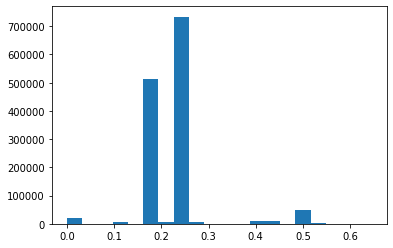

In [19]:
plt.hist(df[features].isna().sum(axis=1) / len(features), bins=20);

In [20]:
s = """feature	description
acc_now_delinq	The number of accounts on which the borrower is now delinquent.
acc_open_past_24mths	Number of trades opened in past 24 months.
addr_state	The state provided by the borrower in the loan application
all_util	Balance to credit limit on all trades
annual_inc	The self-reported annual income provided by the borrower during registration.
annual_inc_joint	The combined self-reported annual income provided by the co-borrowers during registration
application_type	Indicates whether the loan is an individual application or a joint application with two co-borrowers
avg_cur_bal	Average current balance of all accounts
bc_open_to_buy	Total open to buy on revolving bankcards.
bc_util	Ratio of total current balance to high credit/credit limit for all bankcard accounts.
chargeoff_within_12_mths	Number of charge-offs within 12 months
collection_recovery_fee	post charge off collection fee
collections_12_mths_ex_med	Number of collections in 12 months excluding medical collections
delinq_2yrs	The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
delinq_amnt	The past-due amount owed for the accounts on which the borrower is now delinquent.
dti	A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
dti_joint	A ratio calculated using the co-borrowers' total monthly payments on the total debt obligations, excluding mortgages and the requested LC loan, divided by the co-borrowers' combined self-reported monthly income
earliest_cr_line	The month the borrower's earliest reported credit line was opened
emp_length	Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 
emp_title	The job title supplied by the Borrower when applying for the loan.*
fico_range_high	The upper boundary range the borrower’s FICO at loan origination belongs to.
fico_range_low	The lower boundary range the borrower’s FICO at loan origination belongs to.
funded_amnt	The total amount committed to that loan at that point in time.
funded_amnt_inv	The total amount committed by investors for that loan at that point in time.
grade	LC assigned loan grade
home_ownership	The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER
id	A unique LC assigned ID for the loan listing.
il_util	Ratio of total current balance to high credit/credit limit on all install acct
initial_list_status	The initial listing status of the loan. Possible values are – W, F
inq_fi	Number of personal finance inquiries
inq_last_12m	Number of credit inquiries in past 12 months
inq_last_6mths	The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
installment	The monthly payment owed by the borrower if the loan originates.
int_rate	Interest Rate on the loan
issue_d	The month which the loan was funded
last_credit_pull_d	The most recent month LC pulled credit for this loan
last_fico_range_high	The upper boundary range the borrower’s last FICO pulled belongs to.
last_fico_range_low	The lower boundary range the borrower’s last FICO pulled belongs to.
last_pymnt_amnt	Last total payment amount received
last_pymnt_d	Last month payment was received
loan_amnt	The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
loan_status	Current status of the loan
max_bal_bc	Maximum current balance owed on all revolving accounts
member_id	A unique LC assigned Id for the borrower member.
mo_sin_old_il_acct	Months since oldest bank installment account opened
mo_sin_old_rev_tl_op	Months since oldest revolving account opened
mo_sin_rcnt_rev_tl_op	Months since most recent revolving account opened
mo_sin_rcnt_tl	Months since most recent account opened
mort_acc	Number of mortgage accounts.
mths_since_last_delinq	The number of months since the borrower's last delinquency.
mths_since_last_major_derog	Months since most recent 90-day or worse rating
mths_since_last_record	The number of months since the last public record.
mths_since_rcnt_il	Months since most recent installment accounts opened
mths_since_recent_bc	Months since most recent bankcard account opened.
mths_since_recent_bc_dlq	Months since most recent bankcard delinquency
mths_since_recent_inq	Months since most recent inquiry.
mths_since_recent_revol_delinq	Months since most recent revolving delinquency.
next_pymnt_d	Next scheduled payment date
num_accts_ever_120_pd	Number of accounts ever 120 or more days past due
num_actv_bc_tl	Number of currently active bankcard accounts
num_actv_rev_tl	Number of currently active revolving trades
num_bc_sats	Number of satisfactory bankcard accounts
num_bc_tl	Number of bankcard accounts
num_il_tl	Number of installment accounts
num_op_rev_tl	Number of open revolving accounts
num_rev_accts	Number of revolving accounts
num_rev_tl_bal_gt_0	Number of revolving trades with balance >0
num_sats	Number of satisfactory accounts
num_tl_120dpd_2m	Number of accounts currently 120 days past due (updated in past 2 months)
num_tl_30dpd	Number of accounts currently 30 days past due (updated in past 2 months)
num_tl_90g_dpd_24m	Number of accounts 90 or more days past due in last 24 months
num_tl_op_past_12m	Number of accounts opened in past 12 months
open_acc	The number of open credit lines in the borrower's credit file.
open_acc_6m	Number of open trades in last 6 months
open_il_12m	Number of installment accounts opened in past 12 months
open_il_24m	Number of installment accounts opened in past 24 months
open_act_il	Number of currently active installment trades
open_rv_12m	Number of revolving trades opened in past 12 months
open_rv_24m	Number of revolving trades opened in past 24 months
out_prncp	Remaining outstanding principal for total amount funded
out_prncp_inv	Remaining outstanding principal for portion of total amount funded by investors
pct_tl_nvr_dlq	Percent of trades never delinquent
percent_bc_gt_75	Percentage of all bankcard accounts > 75% of limit.
policy_code	"publicly available policy_code=1
new products not publicly available policy_code=2"
pub_rec	Number of derogatory public records
pub_rec_bankruptcies	Number of public record bankruptcies
purpose	A category provided by the borrower for the loan request. 
pymnt_plan	Indicates if a payment plan has been put in place for the loan
recoveries	post charge off gross recovery
revol_bal	Total credit revolving balance
revol_util	Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
sub_grade	LC assigned loan subgrade
tax_liens	Number of tax liens
term	The number of payments on the loan. Values are in months and can be either 36 or 60.
title	The loan title provided by the borrower
tot_coll_amt	Total collection amounts ever owed
tot_cur_bal	Total current balance of all accounts
tot_hi_cred_lim	Total high credit/credit limit
total_acc	The total number of credit lines currently in the borrower's credit file
total_bal_ex_mort	Total credit balance excluding mortgage
total_bal_il	Total current balance of all installment accounts
total_bc_limit	Total bankcard high credit/credit limit
total_cu_tl	Number of finance trades
total_il_high_credit_limit	Total installment high credit/credit limit
total_pymnt	Payments received to date for total amount funded
total_pymnt_inv	Payments received to date for portion of total amount funded by investors
total_rec_int	Interest received to date
total_rec_late_fee	Late fees received to date
total_rec_prncp	Principal received to date
total_rev_hi_lim  	Total revolving high credit/credit limit
verification_status	Indicates if income was verified by LC, not verified, or if the income source was verified
verified_status_joint	Indicates if the co-borrowers' joint income was verified by LC, not verified, or if the income source was verified
zip_code	The first 3 numbers of the zip code provided by the borrower in the loan application.
revol_bal_joint 	 Sum of revolving credit balance of the co-borrowers, net of duplicate balances
sec_app_fico_range_low 	 FICO range (high) for the secondary applicant
sec_app_fico_range_high 	 FICO range (low) for the secondary applicant
sec_app_earliest_cr_line 	 Earliest credit line at time of application for the secondary applicant
sec_app_inq_last_6mths 	 Credit inquiries in the last 6 months at time of application for the secondary applicant
sec_app_mort_acc 	 Number of mortgage accounts at time of application for the secondary applicant
sec_app_open_acc 	 Number of open trades at time of application for the secondary applicant
sec_app_revol_util 	 Ratio of total current balance to high credit/credit limit for all revolving accounts
sec_app_open_act_il	 Number of currently active installment trades at time of application for the secondary applicant
sec_app_num_rev_accts 	 Number of revolving accounts at time of application for the secondary applicant
sec_app_chargeoff_within_12_mths 	 Number of charge-offs within last 12 months at time of application for the secondary applicant
sec_app_collections_12_mths_ex_med 	 Number of collections within last 12 months excluding medical collections at time of application for the secondary applicant
sec_app_mths_since_last_major_derog 	 Months since most recent 90-day or worse rating at time of application for the secondary applicant
hardship_flag	Flags whether or not the borrower is on a hardship plan
hardship_type	Describes the hardship plan offering
hardship_reason	Describes the reason the hardship plan was offered
hardship_status	Describes if the hardship plan is active, pending, canceled, completed, or broken
deferral_term	Amount of months that the borrower is expected to pay less than the contractual monthly payment amount due to a hardship plan
hardship_amount	The interest payment that the borrower has committed to make each month while they are on a hardship plan
hardship_start_date	The start date of the hardship plan period
hardship_end_date	The end date of the hardship plan period
payment_plan_start_date	The day the first hardship plan payment is due. For example, if a borrower has a hardship plan period of 3 months, the start date is the start of the three-month period in which the borrower is allowed to make interest-only payments.
hardship_length	The number of months the borrower will make smaller payments than normally obligated due to a hardship plan
hardship_dpd	Account days past due as of the hardship plan start date
hardship_loan_status	Loan Status as of the hardship plan start date
orig_projected_additional_accrued_interest	The original projected additional interest amount that will accrue for the given hardship payment plan as of the Hardship Start Date. This field will be null if the borrower has broken their hardship payment plan.
hardship_payoff_balance_amount	The payoff balance amount as of the hardship plan start date
hardship_last_payment_amount	The last payment amount as of the hardship plan start date
disbursement_method	The method by which the borrower receives their loan. Possible values are: CASH, DIRECT_PAY
debt_settlement_flag	Flags whether or not the borrower, who has charged-off, is working with a debt-settlement company.
debt_settlement_flag_date	The most recent date that the Debt_Settlement_Flag has been set  
settlement_status	The status of the borrower’s settlement plan. Possible values are: COMPLETE, ACTIVE, BROKEN, CANCELLED, DENIED, DRAFT
settlement_date	The date that the borrower agrees to the settlement plan
settlement_amount	The loan amount that the borrower has agreed to settle for
settlement_percentage	The settlement amount as a percentage of the payoff balance amount on the loan
settlement_term	The number of months that the borrower will be on the settlement plan
""".splitlines()

In [21]:
pd.DataFrame([x.split('\t') for x in s if x.count("\t") and x.split("\t")[0].strip() in features]).style

,0,1
0,addr_state,The state provided by the borrower in the loan application
1,all_util,Balance to credit limit on all trades
2,annual_inc,The self-reported annual income provided by the borrower during registration.
3,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
4,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
5,bc_open_to_buy,Total open to buy on revolving bankcards.
6,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
7,dti_joint,"A ratio calculated using the co-borrowers' total monthly payments on the total debt obligations, excluding mortgages and the requested LC loan, divided by the co-borrowers' combined self-reported monthly income"
8,earliest_cr_line,The month the borrower's earliest reported credit line was opened
9,emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.


In [22]:
set(features) - set([x.split('\t')[0].strip() for x in s if x.count("\t") and x.split("\t")[0].strip() in features])

{'debt_load',
 'desc',
 'fraq_annual_inc',
 'log_annual_inc',
 'verification_status_joint'}